### Fundamentals of Natural Language Processing
# Negation and Uncertainty Detection using a Machine-Learning Based Approach

*Authors:*

> *Anna Blanco, Agustina Lazzati, Stanislav Bultaskii, Queralt Salvadó*

*Aims:*
> Our goal is to train various Machine Learning based models for each of the two sub-tasks (detection of negation and uncertainty signals, and detection of the negation and uncertainty scopes). In order to do so, we followed the implementation method described by *Enger, Velldal, and Øvrelid (2017)*, which employs a maximum-margin approach for negation detection. However, for our particular application, we also included uncertainty cues and scope detection.

*References:* 
<br>
> Enger, M., Velldal, E., & Øvrelid, L. (2017). *An open-source tool for negation detection: A maximum-margin approach*. Proceedings of the Workshop on Computational Semantics Beyond Events and Roles (SemBEaR), 64–69.

---

In [68]:
import spacy

# Check installed models
print(spacy.util.get_installed_models())


['es_core_news_sm']


In [69]:
#!python -m spacy download es_core_news_sm


We first download all the preprocessing. 

In [70]:
# Import necessary libraries and functions
import json
import spacy
from collections import defaultdict
import re
import pandas as pd
from preprocessing import df_svm_neg_test, df_svm_neg_train, df_svm_neg_test, df_svm_unc_train, df_svm_unc_test, df_crf_neg_train, df_crf_neg_test, df_crf_unc_train, df_crf_unc_test

## CUE DETECTION USING SVM
In this section of the notebook, we focus on detecting **negation** and **uncertainty cues** in medical or clinical documents using a **Support Vector Machine (SVM)**. This involves identifying specific words or phrases that signal negation (e.g., *no*, *denies*) or uncertainty (e.g., *possible*, *likely*) within a sentence. The goal is to classify these cues accurately. This complements other components of the notebook such as preprocessing, feature extraction, and model evaluation.

First of all, we'll need to vectorize:

In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer

def prepare_dataframe_for_svm(df, label_col):
    """
    Converts a DataFrame into features and labels for training.
    """
    drop_cols = ["sentence_id", "token_id", label_col]
    feature_dicts = df.drop(columns=drop_cols).to_dict(orient="records")
    labels = df[label_col].tolist()

    vectorizer = DictVectorizer(sparse=True)
    X = vectorizer.fit_transform(feature_dicts)
    y = labels

    return X, y, vectorizer


def train_and_evaluate_svm(df_train, df_test, label_col, model_name):
    """
    Trains and evaluates an SVM model, returning key data for further use.
    """
    # Prepare data
    X_train, y_train, vec = prepare_dataframe_for_svm(df_train, label_col)
    X_test = vec.transform(df_test.drop(columns=["sentence_id", "token_id", label_col]).to_dict(orient="records"))
    y_test = df_test[label_col].tolist()

    # Define and train the SVM model
    svm_model = LinearSVC(class_weight="balanced", max_iter=5000, random_state=42)
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)

    # Report
    print(f"\n--- Evaluation for {model_name} ---")
    print(classification_report(y_test, y_pred, digits=4))


    return X_train, y_train, X_test, y_test, y_pred, svm_model, vec

In [72]:
x, y ,vectorizer = prepare_dataframe_for_svm(df_svm_neg_train, label_col="neg_cue_label")
print(x)

  (0, 14)	1.0
  (0, 31)	0.0
  (0, 46)	1.0
  (0, 50)	0.0
  (0, 51)	0.0
  (0, 52)	0.0
  (0, 53)	0.0
  (0, 54)	1.0
  (0, 19220)	1.0
  (0, 19224)	1.0
  (0, 23909)	1.0
  (0, 28445)	1.0
  (1, 15)	1.0
  (1, 31)	0.0
  (1, 39)	1.0
  (1, 50)	0.0
  (1, 51)	0.0
  (1, 52)	0.0
  (1, 53)	0.0
  (1, 14754)	1.0
  (1, 19213)	1.0
  (1, 22854)	1.0
  (1, 27358)	1.0
  (1, 44032)	1.0
  (2, 0)	1.0
  :	:
  (251967, 43662)	1.0
  (251968, 26)	1.0
  (251968, 31)	0.0
  (251968, 39)	1.0
  (251968, 50)	0.0
  (251968, 51)	0.0
  (251968, 52)	0.0
  (251968, 53)	0.0
  (251968, 3098)	1.0
  (251968, 19214)	1.0
  (251968, 19879)	1.0
  (251968, 24766)	1.0
  (251968, 31561)	1.0
  (251969, 4)	1.0
  (251969, 31)	0.0
  (251969, 39)	1.0
  (251969, 50)	0.0
  (251969, 51)	0.0
  (251969, 52)	0.0
  (251969, 53)	0.0
  (251969, 13490)	1.0
  (251969, 19206)	1.0
  (251969, 22568)	1.0
  (251969, 27454)	1.0
  (251969, 42679)	1.0


### SVM for negation cue detection
we apply a **Support Vector Machine (SVM)** classifier to detect **negation cues**. These cues—such as *no*, *denies*, or *without*—indicate that a condition or finding is explicitly negated. We preprocess the data, extract relevant features, and train the SVM model to identify these negation indicators at the token level.

In [73]:
X_train_negsvm, y_train_negsvm, X_test_negsvm, y_test_negsvm, y_pred_negsvm, neg_svm_model, vectorizer_neg = train_and_evaluate_svm(
    df_train=df_svm_neg_train,
    df_test=df_svm_neg_test,
    label_col="neg_cue_label",
    model_name="svm_negation_cue"
)

c:\Users\Agusl\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



--- Evaluation for svm_negation_cue ---
              precision    recall  f1-score   support

           0     0.9999    0.9984    0.9992     64399
           1     0.9163    0.9956    0.9543      1132

    accuracy                         0.9984     65531
   macro avg     0.9581    0.9970    0.9767     65531
weighted avg     0.9985    0.9984    0.9984     65531



c:\Users\Agusl\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### SVM for uncertainty cue detection
Now, we apply a **Support Vector Machine (SVM)** classifier to detect **uncertainty cues**. Uncertainty cues, such as *possible*, *likely*, or *suggests*, signal that the presence of a condition or outcome is not definite. This complements the negation cue detection and enhances the overall cue detection framework.

In [74]:
X_train_svmunc, y_train_svmunc, X_test_svmunc, y_test_svmunc, y_pred_svmunc, model_svmunc, vectorizer_unc = train_and_evaluate_svm(
    df_train=df_svm_unc_train,
    df_test=df_svm_unc_test,
    label_col="unc_cue_label",
    model_name="svm_uncertainty_cue"
)

c:\Users\Agusl\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Agusl\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



--- Evaluation for svm_uncertainty_cue ---
              precision    recall  f1-score   support

           0     0.9998    0.9331    0.9653     65332
           1     0.0415    0.9497    0.0795       199

    accuracy                         0.9332     65531
   macro avg     0.5207    0.9414    0.5224     65531
weighted avg     0.9969    0.9332    0.9626     65531



Since we found that the dataset wasn’t balanced, we tried balancing the training data by undersampling the majority class. This helps prevent the model from being biased toward the dominant class and improves its ability to detect the minority class cues more effectively.

In [75]:
def balance_training_data(df, label_col, neg_ratio=4, seed=42):
    """
    Balance the training data by undersampling the negative class.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing the training data.
    - label_col (str): The name of the column in df that contains the binary labels (0 for negative, 1 for positive).
    - neg_ratio (int, default=4): The desired ratio of negative to positive samples in the balanced dataset.
    - seed (int, default=42): Random seed for reproducibility during sampling.

    Returns:
    - pd.DataFrame: A new DataFrame balanced with all positive samples and a sampled subset of negative samples
      according to the specified negative-to-positive ratio. The resulting DataFrame is shuffled.
    """

    positives = df[df[label_col] == 1]
    negatives = df[df[label_col] == 0].sample(n=len(positives) * neg_ratio, random_state=seed)
    df_balanced = pd.concat([positives, negatives]).sample(frac=1, random_state=seed).reset_index(drop=True)
    return df_balanced

df_balanced_unc_train = balance_training_data(df_svm_unc_train, label_col="unc_cue_label", neg_ratio=4)
print(df_balanced_unc_train["unc_cue_label"].value_counts())
df_balanced_unc_test = balance_training_data(df_svm_unc_test, label_col="unc_cue_label", neg_ratio=4)
print(df_balanced_unc_test["unc_cue_label"].value_counts())

0    2744
1     686
Name: unc_cue_label, dtype: int64
0    796
1    199
Name: unc_cue_label, dtype: int64


In [76]:
X_train_svmunc, y_train_svmunc, X_test_svmunc, y_test_svmunc, y_pred_svmunc, model_svmunc, vectorizer = train_and_evaluate_svm(
    df_train=df_balanced_unc_train,
    df_test=df_balanced_unc_test,
    label_col="unc_cue_label",
    model_name="svm_uncertainty_cue_balanced"
)


--- Evaluation for svm_uncertainty_cue_balanced ---
              precision    recall  f1-score   support

           0     0.9922    0.9573    0.9744       796
           1     0.8502    0.9698    0.9061       199

    accuracy                         0.9598       995
   macro avg     0.9212    0.9636    0.9403       995
weighted avg     0.9638    0.9598    0.9608       995



c:\Users\Agusl\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [77]:
def compute_per_label_accuracy(y_true, y_pred, label_mapping, title="Per-label Accuracy"):
    """
    Computes and prints accuracy for each label individually.

    Parameters:
    - y_true: list of true labels (numeric or string).
    - y_pred: list of predicted labels (numeric or string).
    - label_mapping: dict mapping numeric labels to human-readable strings.
    - title: optional title for the printed output.

    The function maps labels to readable names, filters out irrelevant labels (like 'O'),
    calculates accuracy per label as the ratio of correctly predicted instances over total true instances,
    and prints the accuracies in a formatted way.
    """
    # Map numeric labels to readable ones (if needed)
    y_true_named = [label_mapping.get(y, y) for y in y_true]
    y_pred_named = [label_mapping.get(y, y) for y in y_pred]

    # Get all relevant labels, excluding "O" if applicable
    unique_labels = sorted(set(label for label in y_true_named if label != 'O'))

    # Compute accuracy per label (correct predictions / total true instances)
    per_label_accuracies = {}
    for label in unique_labels:
        total = sum(1 for y in y_true_named if y == label)
        correct = sum(1 for yt, yp in zip(y_true_named, y_pred_named) if yt == label and yp == label)
        per_label_accuracies[label] = correct / total if total > 0 else 0.0

    # Print results
    print(f"\n{title}:")
    for label, acc in per_label_accuracies.items():
        print(f"{label:<10}: {acc:.4f}")


In [78]:
compute_per_label_accuracy(
    y_true=y_test_svmunc,
    y_pred=y_pred_svmunc,
    label_mapping={1: "UNC", 0: "NOT UNC"},
    title="Per-label Accuracy for SVM Uncertainty Cue Detection"
)

compute_per_label_accuracy(
    y_true=y_test_negsvm,
    y_pred=y_pred_negsvm,
    label_mapping={1: "NEG", 0: "NOT NEG"},
    title="Per-label Accuracy for SVM Negation Cue Detection"
)



Per-label Accuracy for SVM Uncertainty Cue Detection:
NOT UNC   : 0.9573
UNC       : 0.9698

Per-label Accuracy for SVM Negation Cue Detection:
NEG       : 0.9956
NOT NEG   : 0.9984


## SCOPE DETECTION USING CRF

In [79]:
# pip install sklearn-crfsuite

We'll use CRF BIO tagging:

**BIO tagging** is a way to label each word in a sentence to show if it is part of a scope (like negation or uncertainty). The labels are:

* **B** for the **Beginning** of the scope
* **I** for **Inside** the scope
* **O** for **Outside** the scope

We use BIO tagging to help machine learning models, like **CRFs (Conditional Random Fields)**, understand where a scope starts and ends. For example, if a sentence has a negation like “No tiene fiebre”, BIO tagging shows that “No” is the beginning (**B-SCOPE**) and “tiene fiebre” is inside the scope (**I-SCOPE**), while other words would be labeled **O** if they are not part of it.

Using BIO makes it easier for the model to learn patterns and detect complete scopes correctly, not just single words. 


In [80]:
#   IM GETTING ALL THE NEGATION AND THE UNC CUES FROM TRAIN DATAFRAME, 
#   maybe it should be done with the svm but i dont how. 
neg_cues = set()
unc_cues = set()
for _, row in df_svm_neg_train.iterrows():
    if row['neg_cue_label'] == 1:
        neg_cues.add(row['word'].lower())

for _, row in df_svm_unc_train.iterrows():
    if row['unc_cue_label'] == 1:
        unc_cues.add(row['word'].lower())


In [81]:
from sklearn_crfsuite import CRF
from sklearn_crfsuite import metrics

def to_bio_labels(labels, label_type="SCOPE"):
    """
    Convert lists of binary labels (0/1) into BIO tagging format with custom suffixes.

    Parameters:
    - labels: list of lists, where each inner list contains binary labels (0 or 1) for a sentence.
    - label_type: string indicating the type of label ('neg', 'unc', or others) to customize BIO suffix.

    Returns:
    - bio_labels: list of lists, where each inner list contains BIO-formatted tags.
    """
    # Convert lists of binary labels (0/1) into BIO tagging format with custom suffixes
    bio_labels = []
    
    # Map original suffixes to new ones
    if "neg" in label_type.lower():
        prefix = "NSCO"   # Instead of NEG_SCOPE
    elif "unc" in label_type.lower():
        prefix = "UNSCO"  # Instead of UNC_SCOPE
    else:
        prefix = label_type.upper()  # fallback

    for sent in labels:
        bio = []
        prev = 0
        for i, tag in enumerate(sent):
            if tag == 1:
                if i == 0 or prev == 0:
                    bio.append(f'B-{prefix}')
                else:
                    bio.append(f'I-{prefix}')
            else:
                bio.append('O')
            prev = tag
        bio_labels.append(bio)
    return bio_labels

def df_to_crf_format(df, task, neg_cues=neg_cues, unc_cues=unc_cues):
    """
    Convert a DataFrame into a list of feature dictionaries per sentence for CRF input.
    Includes original features + contextual features + lexicon-based features.
    
    Parameters:
        df (pd.DataFrame): must contain columns like 'word', 'pos', 'prefix', 'suffix', etc.

    Returns:
        List of list of feature dicts (one per token, grouped by sentence)
    """
    sentences = []
    grouped = df.groupby("sentence_id")

    for _, group in grouped:
        sentence = []
        group = group.reset_index(drop=True)  # Reset index so we can use idx in loop

        for idx, row in group.iterrows():
            word_lower = row['word'].lower()

            features = {
                'word.lower()': word_lower,
                'word.isupper()': row['word'].isupper(),
                'word.istitle()': row['word'].istitle(),
                'pos': row['pos'],
                'pos_prefix': row['pos'][:2] if isinstance(row['pos'], str) else 'NA',
                'prefix': row['prefix'],
                'suffix': row['suffix'],
                'is_punct': row['is_punct'],
                'in_single_word_cues': row['in_single_word_cues'],
                'in_affixal_cues': row['in_affixal_cues'],
                'ends_with_ment': row['ends_with_ment'],
                'has_neg_prefix': word_lower.startswith(('un', 'in', 'non', 'dis')),
                'has_neg_suffix': word_lower.endswith(('less', "n't")),
                'is_modal': word_lower in unc_cues if task == "UNC" else word_lower in neg_cues
            }
    
            # dependency features --> Put in table
            if 'dep' in row and 'head_word' in row and 'head_pos' in row:
                features.update({
                    'dep_label': row['dep'],
                    'head_word': str(row['head_word']).lower(),
                    'head_pos': row['head_pos']
                })

            # Contextual features: previous and next token
            if idx > 0:
                prev_row = group.iloc[idx - 1]
                features.update({
                    '-1:word.lower()': prev_row['word'].lower(),
                    '-1:pos': prev_row['pos']
                })
            else:
                features['BOS'] = True  # Beginning of sentence

            if idx < len(group) - 1:
                next_row = group.iloc[idx + 1]
                features.update({
                    '+1:word.lower()': next_row['word'].lower(),
                    '+1:pos': next_row['pos']
                })
            else:
                features['EOS'] = True  # End of sentence

            sentence.append(features)
        sentences.append(sentence)

    return sentences


def df_to_labels(df, label_col):
    """
    Extract sequences of labels from a DataFrame grouped by sentence.

    Parameters:
    - df: pandas DataFrame containing 'sentence_id' and the label column.
    - label_col: string, the name of the column in df with the labels.

    Returns:
    - label_sequences: list of lists, where each inner list contains the labels for a sentence,
      preserving the order of tokens within the sentence.
    """
    # Extracts label sequences from the DataFrame, grouped by sentence
    # Groups the label colum into per-sentence list.
    label_sequences = []
    grouped = df.groupby("sentence_id")
    for _, group in grouped:
        label_list = group[label_col].tolist()
        label_sequences.append(label_list)
    return label_sequences


#### Training and evaluating the CRF model
In this section, we train a Conditional Random Field (CRF) model to perform sequence labeling on medical text, identifing negation and uncertainty scopes using BIO tagging.

In [82]:
# Train + evaluate CRF model
def train_and_evaluate_crf(df_train, df_test, label_col):
    """
    Train and evaluate a CRF model for sequence labeling (BIO tagging) on a specified label column.

    Parameters:
    - df_train: training DataFrame with tokens and labels
    - df_test: test DataFrame with tokens and labels
    - label_col: string, the name of the column containing the BIO labels to predict 
                 (e.g., 'neg_scope_label' or 'unc_scope_label')

    Returns:
    - X_test: list of feature dicts for the test set (used for further evaluation or predictions)
    - y_test: list of BIO tag sequences (true labels) for the test set
    - y_pred: list of BIO tag sequences predicted by the CRF model on the test set
    """
    # Trains and evaluates a CRF model for BIO tagging using specified label column (e.g., 'neg_scope_label')
    scope_type = "NEG" if "neg" in label_col.lower() else "UNC"

    X_train = df_to_crf_format(df_train, scope_type)
    y_train_raw = df_to_labels(df_train, label_col) # Labels for BIO tagging ¿Preprocessing?
    y_train = to_bio_labels(y_train_raw, label_type=scope_type)

    X_test = df_to_crf_format(df_test, scope_type)
    y_test_raw = df_to_labels(df_test, label_col)
    y_test = to_bio_labels(y_test_raw, label_type=scope_type)

    crf = CRF(algorithm='lbfgs', 
              c1=0.1, c2=0.1,
              max_iterations=100, all_possible_transitions=True)
    
    crf.fit(X_train, y_train)
    y_pred = crf.predict(X_test)

    print(f"CRF Evaluation for: {label_col.upper()}")
    print(metrics.flat_classification_report(y_test, y_pred, digits=4))   
    
    return X_test, y_test, y_pred  # Return these variables for further use


### CRF for negation scope detection

In [83]:
# CRF BIO tagging evaluation for NEGATION scopes
X_test_NEG, y_test_NEG, y_pred_NEG = train_and_evaluate_crf(df_crf_neg_train, df_crf_neg_test, "neg_scope_label")

CRF Evaluation for: NEG_SCOPE_LABEL
              precision    recall  f1-score   support

      B-NSCO     0.9633    0.9066    0.9341      1071
      I-NSCO     0.8965    0.7831    0.8360      2522
           O     0.9897    0.9958    0.9927     61938

    accuracy                         0.9862     65531
   macro avg     0.9498    0.8952    0.9209     65531
weighted avg     0.9857    0.9862    0.9857     65531



### CRF for uncertainty scope detection

In [84]:
# CRF BIO tagging evaluation for UNCERTAINTY scopes
X_test_UNC, y_test_UNC, y_pred_UNC = train_and_evaluate_crf(df_crf_unc_train, df_crf_unc_test, "unc_scope_label")

CRF Evaluation for: UNC_SCOPE_LABEL
              precision    recall  f1-score   support

     B-UNSCO     0.7963    0.3333    0.4699       129
     I-UNSCO     0.6590    0.3936    0.4928       437
           O     0.9947    0.9985    0.9966     64965

    accuracy                         0.9932     65531
   macro avg     0.8167    0.5751    0.6531     65531
weighted avg     0.9921    0.9932    0.9922     65531



In [85]:
df_balanced_unc_train = balance_training_data(df_crf_unc_train, label_col="unc_scope_label", neg_ratio=4)
print(df_balanced_unc_train["unc_scope_label"].value_counts())
df_balanced_unc_test = balance_training_data(df_crf_unc_test, label_col="unc_scope_label", neg_ratio=4)
print(df_balanced_unc_test["unc_scope_label"].value_counts())
X_test_UNC_balance, y_test_UNC_balance, y_pred_UNC_balance = train_and_evaluate_crf(df_balanced_unc_train, df_balanced_unc_test, "unc_scope_label")

0    8372
1    2093
Name: unc_scope_label, dtype: int64
0    2264
1     566
Name: unc_scope_label, dtype: int64
CRF Evaluation for: UNC_SCOPE_LABEL
              precision    recall  f1-score   support

     B-UNSCO     0.5326    0.3267    0.4050       150
     I-UNSCO     0.7950    0.7644    0.7794       416
           O     0.9333    0.9638    0.9483      2264

    accuracy                         0.9007      2830
   macro avg     0.7536    0.6850    0.7109      2830
weighted avg     0.8917    0.9007    0.8947      2830



In [86]:
# TABLE WITH ALL COMBINED EXCLUDING THE OUTOFSCOPE: 
# Combine the BIO label sequences
y_test_all = y_test_NEG + y_test_UNC_balance
y_pred_all = y_pred_NEG + y_pred_UNC_balance

# Get all labels except 'O'
all_labels = set(label for seq in y_test_all for label in seq if label != 'O')
all_labels = sorted(all_labels)

# Print overall evaluation
print("Overall Evaluation (NEG + UNC scopes):")
print(metrics.flat_classification_report(
    y_test_all, y_pred_all, labels=all_labels, digits=4))

Overall Evaluation (NEG + UNC scopes):
              precision    recall  f1-score   support

      B-NSCO     0.9633    0.9066    0.9341      1071
     B-UNSCO     0.5326    0.3267    0.4050       150
      I-NSCO     0.8965    0.7831    0.8360      2522
     I-UNSCO     0.7950    0.7644    0.7794       416

   micro avg     0.8947    0.7966    0.8428      4159
   macro avg     0.7969    0.6952    0.7386      4159
weighted avg     0.8904    0.7966    0.8400      4159



In [87]:
# Flatten the sequences
true_labels = [label for seq in y_test_all for label in seq]
pred_labels = [label for seq in y_pred_all for label in seq]

# Call the function
compute_per_label_accuracy(
    y_true=true_labels,
    y_pred=pred_labels,
    label_mapping={},
    title="Per-label Accuracy for CRF Scope"
)


Per-label Accuracy for CRF Scope:
B-NSCO    : 0.9066
B-UNSCO   : 0.3267
I-NSCO    : 0.7831
I-UNSCO   : 0.7644


## Printing CRF Predictions vs. True labels
We display sample sentences with predicted and true BIO tags shown as `[true_tag|pred_tag]` next to each word, only if at least one tag isn't `'O'`. This highlights where the model correctly identifies scopes or makes mistakes, helping us quickly assess its performance on meaningful cases.

In [88]:
def print_predictions(df, y_true, y_pred, sentence_idx=0):
    """
    Print the whole sentence in one line, adding true and predicted BIO tags in brackets next to tokens
    only if the tags are not 'O' (for BIO) or '0' (for SVM).
    Format per token: word[true_tag|pred_tag] if either tag != 'O' or '0', else just word.
    """
    grouped = df.groupby("sentence_id")
    sentence_ids = list(grouped.groups.keys())

    if sentence_idx >= len(sentence_ids):
        print(f"Invalid sentence index {sentence_idx}. Max allowed: {len(sentence_ids) - 1}")
        return

    sentence_id = sentence_ids[sentence_idx]
    sentence_df = grouped.get_group(sentence_id).reset_index(drop=True)
    
    output_tokens = []
    for i, row in sentence_df.iterrows():
        word = row['word']
        true_label = y_true[sentence_idx][i]
        pred_label = y_pred[sentence_idx][i]

        # Show tags only if either true or pred label is not neutral ('O' for BIO, '0' for SVM)
        if (true_label != 'O' and true_label != 0 and true_label != '0') or (pred_label != 'O' and pred_label != 0 and pred_label != '0'):
            display_word = f"{word} [{true_label}|{pred_label}]"
        else:
            display_word = word

        output_tokens.append(display_word)

    print(f"\n--- Sentence ID {sentence_id} ---")
    print(" ".join(output_tokens))


In [89]:
shown = 0
max_to_show = 10

print('NSCO EXAMPLES --------------\n')
for i in range(len(y_test_NEG)):
    if any(tag != 'O' for tag in y_test_NEG[i]) or any(tag != 'O' for tag in y_pred_NEG[i]):
        print_predictions(df_crf_neg_test, y_test_NEG, y_pred_NEG, sentence_idx=i)
        shown += 1
        if shown >= max_to_show:
            break

NSCO EXAMPLES --------------


--- Sentence ID 1 ---
nº historia clinica : * * * * * * * * nºepisodi : * * * * * * * * sexe : dona data de naixement : 12.05.1977 edat : 42 anys procedencia aguts servei obstetricia data d'ingres 27.09.2019 data d'alta 01.10.2019 13:00:00 ates per * * * * * * * * * * * * * * * * * , * * * * * * * * * * * * * * ; * * * * * * * * * * * * * * * * * , * * * * * informe d'alta d'hospitalitzacio motiu d'ingres induccion al parto por pequeño para la edad gestacional ( peg ) antecedents no alergias [B-NSCO|B-NSCO] medicamentosas [I-NSCO|I-NSCO] conocidas antcededentes medico-quirurgicos : protesis mamaria , adenoidectomia niega habitos [B-NSCO|B-NSCO] toxicos [I-NSCO|I-NSCO] medicacio habitual anafranil25 mg/ diario .

--- Sentence ID 10 ---
vih [B-NSCO|B-NSCO] negativo .

--- Sentence ID 11 ---
serologias : rubeola no inmune [B-NSCO|B-NSCO] , toxoplasma no immune [B-NSCO|B-NSCO] , lues [B-NSCO|B-NSCO] vih [I-NSCO|I-NSCO] , [I-NSCO|I-NSCO] vhb [I-NSCO|I-NSCO] y 

In [90]:
shown = 0
max_to_show = 10

print('UNSCO EXAMPLES --------------\n')
for i in range(len(y_test_UNC)):
    if any(tag != 'O' for tag in y_test_UNC[i]) or any(tag != 'O' for tag in y_pred_UNC[i]):
        print_predictions(df_crf_unc_test, y_test_UNC, y_pred_UNC, sentence_idx=i)
        shown += 1
        if shown >= max_to_show:
            break

UNSCO EXAMPLES --------------


--- Sentence ID 138 ---
dado cuadro clinico y analitico que podria ser [B-UNSCO|O] compatible [I-UNSCO|O] con [I-UNSCO|O] sd [I-UNSCO|O] mononucleosido [I-UNSCO|O] se amplia estudio con determinacion de pcr de parvovirus b19 , toxoplasma y vhh-6 , con resultados pendientes .

--- Sentence ID 140 ---
orientacio diagnostica b34.9 infeccio virica no especificada neutropenia autolimitada fiebre de origen desconocido , posible viriasis [B-UNSCO|B-UNSCO] . [O|I-UNSCO]

--- Sentence ID 156 ---
antecedentes patologicos - elevacion de transaminasas posiblemente secundario [B-UNSCO|O] a [I-UNSCO|O] consumo [I-UNSCO|O] enolico [I-UNSCO|O] . [I-UNSCO|O]

--- Sentence ID 188 ---
hipoestesia simetrica en mmii hasta abdomen ( sin claro nivel [B-UNSCO|O] ) [I-UNSCO|O] .

--- Sentence ID 193 ---
atrofia hipotenar y posible atrofia [B-UNSCO|B-UNSCO] interoseos [I-UNSCO|I-UNSCO] ( paciente refiere que siempre ha permanecido asi ) .

--- Sentence ID 228 ---
por las caracter

## Printing SVM Predictions vs. True labels
Again, we display sample sentences with predicted and true SVM tags shown as `[true_tag|pred_tag]` next to each word. However, since the SVM had as labels 0|1 we had to mapped the labels to obtain a pretty print

In [91]:
def group_labels_by_sentence(df, labels):
    """
     Groups a flat list of labels by sentence based on sentence_id from the DataFrame, since the SVM retrieves 0 and 1.
    """
    grouped = df.groupby("sentence_id")
    grouped_labels = []
    start = 0
    for sentence_id, group in grouped:
        length = len(group)
        grouped_labels.append(labels[start:start+length])
        start += length
    return grouped_labels

def map_labels(grouped_labels, tag):
    """
    Map labels in grouped format:
    - '1' or 1 → tag name (e.g., 'NEG', 'UNC')
    - '0' or 0 → '0'
    """
    return [[(tag if str(label) == '1' else 'O') for label in sentence] for sentence in grouped_labels]


# Group your flat label lists by sentence
y_test_svmunc_grouped = group_labels_by_sentence(df_svm_unc_test, y_test_svmunc)
y_pred_svmunc_grouped = group_labels_by_sentence(df_svm_unc_test, y_pred_svmunc)

y_test_svmunc_grouped_mapped = map_labels(y_test_svmunc_grouped, 'UNC')
y_pred_svmunc_grouped_mapped = map_labels(y_pred_svmunc_grouped, 'UNC')

shown = 0
max_to_show = 10

print('UNCERTAINTY EXAMPLES --------------\n')
for i in range(len(y_test_svmunc_grouped_mapped)):
    # Check if any label is UNC (i.e., '1') in original numeric labels
    if any(tag != '0' and tag != 0 for tag in y_test_svmunc_grouped[i]) or any(tag != '0' and tag != 0 for tag in y_pred_svmunc_grouped[i]):
        print_predictions(df_svm_unc_test, y_test_svmunc_grouped_mapped, y_pred_svmunc_grouped_mapped, sentence_idx=i)
        shown += 1
        if shown >= max_to_show:
            break

UNCERTAINTY EXAMPLES --------------


--- Sentence ID 1 ---
nº historia clinica : * * * * [UNC|UNC] * * [O|UNC] * * nºepisodi : [UNC|UNC] * * * [UNC|UNC] * [UNC|UNC] * * * * sexe [UNC|UNC] : dona data [UNC|UNC] de naixement : [UNC|UNC] 12.05.1977 [UNC|UNC] edat : 42 anys procedencia aguts servei obstetricia data d'ingres [UNC|UNC] 27.09.2019 data d'alta 01.10.2019 13:00:00 [UNC|UNC] ates [UNC|UNC] per * [UNC|UNC] * * * * [O|UNC] * * * * * * [UNC|UNC] * * * * [O|UNC] * [UNC|UNC] * , [O|UNC] * * * * * * [UNC|UNC] * [O|UNC] * * * [UNC|UNC] * * [UNC|UNC] * * ; [UNC|UNC] * * * * * * * [O|UNC] * [UNC|UNC] * [UNC|UNC] * * * * * * * * , * * * [O|UNC] * * [UNC|UNC] informe d'alta d'hospitalitzacio motiu d'ingres induccion al parto por pequeño para la edad gestacional ( peg ) antecedents no alergias medicamentosas [UNC|UNC] conocidas antcededentes medico-quirurgicos [UNC|UNC] : protesis [UNC|O] mamaria [UNC|UNC] , [UNC|UNC] adenoidectomia niega habitos toxicos medicacio habitual anafranil25 mg/ 

In [92]:
print('NEGATION EXAMPLES --------------\n')

# Group your flat label lists by sentence
y_test_svmneg_grouped = group_labels_by_sentence(df_svm_neg_test, y_test_negsvm)
y_pred_svmneg_grouped = group_labels_by_sentence(df_svm_neg_test, y_pred_negsvm)

# Map 0/1 to '0'/'NEG'
y_test_svmneg_grouped_mapped = map_labels(y_test_svmneg_grouped, 'NEG')
y_pred_svmneg_grouped_mapped = map_labels(y_pred_svmneg_grouped, 'NEG')

shown = 0
max_to_show = 10

for i in range(len(y_test_svmneg_grouped)):
    # Show only if there's a non-zero label in the original values
    if any(tag != '0' and tag != 0 for tag in y_test_svmneg_grouped[i]) or any(tag != '0' and tag != 0 for tag in y_pred_svmneg_grouped[i]):
        print_predictions(df_svm_neg_test, y_test_svmneg_grouped_mapped, y_pred_svmneg_grouped_mapped, sentence_idx=i)
        shown += 1
        if shown >= max_to_show:
            break


NEGATION EXAMPLES --------------


--- Sentence ID 1 ---
nº historia clinica : * * * * * * * * nºepisodi : * * * * * * * * sexe : dona data de naixement : 12.05.1977 edat : 42 anys procedencia aguts servei obstetricia data d'ingres 27.09.2019 data d'alta 01.10.2019 13:00:00 ates per * * * * * * * * * * * * * * * * * , * * * * * * * * * * * * * * ; * * * * * * * * * * * * * * * * * , * * * * * informe d'alta d'hospitalitzacio motiu d'ingres induccion al parto por pequeño para la edad gestacional ( peg ) antecedents no [NEG|NEG] alergias medicamentosas conocidas antcededentes medico-quirurgicos : protesis mamaria , adenoidectomia niega [NEG|NEG] habitos toxicos medicacio habitual anafranil25 mg/ diario .

--- Sentence ID 10 ---
vih negativo [NEG|NEG] .

--- Sentence ID 11 ---
serologias : rubeola no [NEG|NEG] inmune , toxoplasma no [NEG|NEG] immune , lues vih , vhb y vhc negativos [NEG|NEG] .

--- Sentence ID 12 ---
- triple screening : 1/14045 down i 1/60540 edwards - riesgo de pe : baj

### Overall Results: SVM + CRF
In this section, we consolidate and summarize the results from both the SVM-based cue detection and the CRF-based scope detection models. By grouping the performance metrics and visualizations, we provide a comprehensive overview of how the combined approach performs across all tasks. 

In [93]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def flatten(seq_list):
    return [label for seq in seq_list for label in seq]

# Cue detection: true and predicted labels
cue_true = df_svm_neg_test["neg_cue_label"].tolist() + df_svm_unc_test["unc_cue_label"].tolist()
cue_pred = list(neg_svm_model.predict(X_test_negsvm)) + list(model_svmunc.predict(X_test_svmunc))

# Scope detection: true and predicted
scope_true = flatten(y_test_NEG) + flatten(y_test_UNC)
scope_pred = flatten(y_pred_NEG) + flatten(y_pred_UNC)

# Filter out neutral classes (non-cues and non-scopes)
cue_true_filtered = [true for true, pred in zip(cue_true, cue_pred) if true != '0']
cue_pred_filtered = [pred for true, pred in zip(cue_true, cue_pred) if true != '0']

scope_true_filtered = [true for true, pred in zip(scope_true, scope_pred) if true != 'O']
scope_pred_filtered = [pred for true, pred in zip(scope_true, scope_pred) if true != 'O']

# Combine filtered cue and scope labels
y_true_all = cue_true_filtered + scope_true_filtered
y_pred_all = cue_pred_filtered + scope_pred_filtered

# Calculate evaluation metrics
accuracy = accuracy_score(y_true_all, y_pred_all)
precision = precision_score(y_true_all, y_pred_all, average="weighted", zero_division=0)
recall = recall_score(y_true_all, y_pred_all, average="weighted", zero_division=0)
f1 = f1_score(y_true_all, y_pred_all, average="weighted", zero_division=0)

In [94]:
# Output the results
print("\nFiltered Overall Evaluation (Cue + Scope Detection):")
print(f"{'Metric':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
print(f"{'Overall':<10}  {accuracy:.4f}     {precision:.4f}    {recall:.4f}      {f1:.4f}")



Filtered Overall Evaluation (Cue + Scope Detection):
Metric     Accuracy   Precision  Recall     F1 Score  
Overall     0.9811     0.9961    0.9811      0.9868


## Visualizing Results: Confusion Matrices per Label
To better understand the performance of our models, we visualize confusion matrices for each label class. Confusion matrices provide a detailed breakdown of true positives, false positives, true negatives, and false negatives, helping us identify which labels are being predicted well and where the model may be confusing certain classes. 


In [95]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_task_confusion_matrices(
    y_test_negsvm, y_pred_negsvm,
    y_test_svmunc, y_pred_svmunc,
    y_test_NEG, y_pred_NEG,
    y_test_UNC, y_pred_UNC
):
    def binary_label_map(y, label_type):
        return [f"{label_type}" if v == 1 else f"NOT {label_type}" for v in y]

    def flatten(seqs):
        return [label for seq in seqs for label in seq]

    def plot_cm(ax, y_true, y_pred, labels, title):
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu', xticklabels=labels, yticklabels=labels, ax=ax)
        ax.set_title(title)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=0)

    # Convert 0/1 to string labels
    y_test_neg_named = binary_label_map(y_test_negsvm, "NEG")
    y_pred_neg_named = binary_label_map(y_pred_negsvm, "NEG")
    y_test_unc_named = binary_label_map(y_test_svmunc, "UNC")
    y_pred_unc_named = binary_label_map(y_pred_svmunc, "UNC")

    # Flatten scope labels
    y_test_neg_scope = flatten(y_test_NEG)
    y_pred_neg_scope = flatten(y_pred_NEG)
    y_test_unc_scope = flatten(y_test_UNC)
    y_pred_unc_scope = flatten(y_pred_UNC)

    # Label sets
    neg_cue_labels = ["NOT NEG", "NEG"]
    unc_cue_labels = ["NOT UNC", "UNC"]
    neg_scope_labels = sorted(set(y_test_neg_scope + y_pred_neg_scope))
    unc_scope_labels = sorted(set(y_test_unc_scope + y_pred_unc_scope))

    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    plot_cm(axs[0, 0], y_test_neg_named, y_pred_neg_named, neg_cue_labels, "Confusion Matrix for NEG")
    plot_cm(axs[0, 1], y_test_unc_named, y_pred_unc_named, unc_cue_labels, "Confusion Matrix for UNC")
    plot_cm(axs[1, 0], y_test_neg_scope, y_pred_neg_scope, neg_scope_labels, "Confusion Matrix for NSCO")
    plot_cm(axs[1, 1], y_test_unc_scope, y_pred_unc_scope, unc_scope_labels, "Confusion Matrix for USCO")

    plt.tight_layout()
    plt.show()


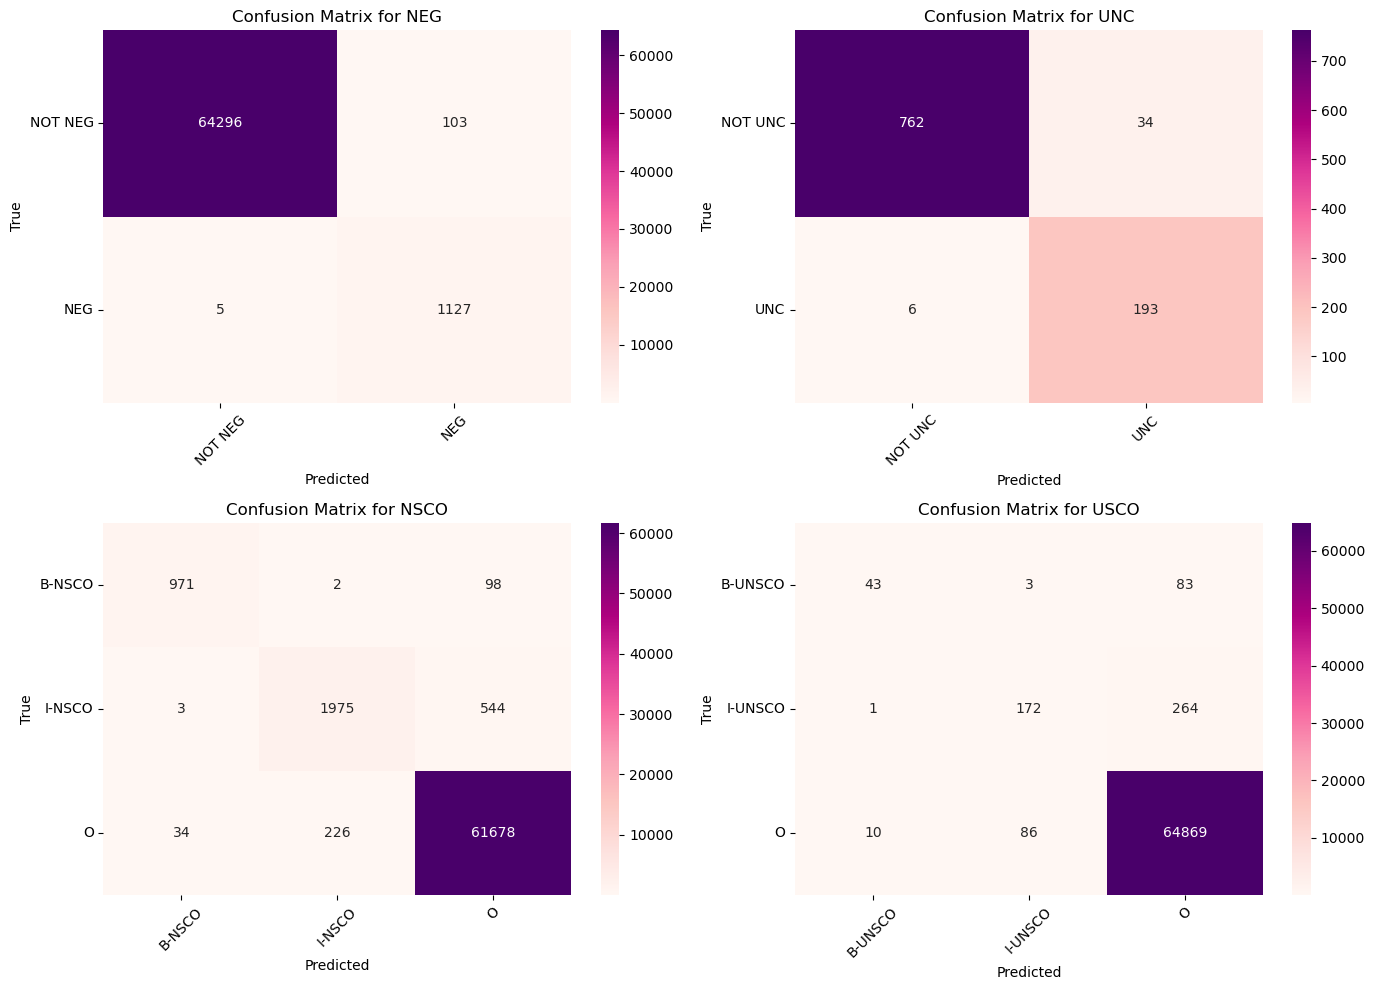

In [96]:
plot_task_confusion_matrices(
    y_test_negsvm, y_pred_negsvm,
    y_test_svmunc, y_pred_svmunc,
    y_test_NEG, y_pred_NEG,
    y_test_UNC, y_pred_UNC
)
